In [31]:
import torch
from PIL import Image
import sys
from pathlib import Path

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from metric_depth.zoedepth.models.builder import build_model
from metric_depth.zoedepth.utils.config import get_config
from metric_depth.zoedepth.utils.misc import save_raw_16bit, colorize

# Load the model
config = get_config("zoedepth", "eval", "nyu")
config.pretrained_resource = "local::./checkpoints/depth_anything_metric_depth_indoor.pt"
zoe = build_model(config).to('cuda' if torch.cuda.is_available() else 'cpu')

Params passed to Resize transform:
	width:  518
	height:  392
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  14
	resize_method:  minimal
Using pretrained resource local::./checkpoints/depth_anything_metric_depth_indoor.pt
Loaded successfully


In [32]:
image = Image.open("/home/emilia/MasterOfFish/sintef_data/YC1/frames/left/frame_0.jpg")
depth = zoe.infer_pil(image)

# output_path = "/home/emilia/MasterOfFish/sintef_data/YC1/depthAny/depth_0.png"
# save_raw_16bit(depth, output_path)

colorized = colorize(depth, cmap="plasma")
output_path = "/home/emilia/MasterOfFish/sintef_data/YC1/depthAny/indoor_nyu.png"
Image.fromarray(colorized).save(output_path)

In [51]:
import sys
from pathlib import Path

root_dir = Path().resolve().parent.parent  
sys.path.append(str(root_dir))


from Baseline.lib.calibration import StereoManager, CameraParameters, StereoParameters
calib_path = "/home/emilia/MasterOfFish/StereoDepth/stereoMap.pickle"

sm = StereoManager()
sm.load_calibration(calib_path)

left_fx = sm.cam_parameters[0].camera_matrix[0, 0]
left_fy = sm.cam_parameters[0].camera_matrix[1,1]

right_fx = sm.cam_parameters[1].camera_matrix[0, 0]
right_fy = sm.cam_parameters[1].camera_matrix[1,1]




In [52]:
import argparse
import os
import glob
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import open3d as o3d
from tqdm import tqdm
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
import pandas as pd

# Global settings
FL = 715.0873
FY = left_fy
FX = left_fx
NYU_DATA = False
FINAL_HEIGHT = 256
FINAL_WIDTH = 256
INPUT_DIR = './my_test/input'
OUTPUT_DIR = './my_test/output'
DATASET = 'kitti' 

def process_images(model):
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    image_paths = glob.glob(os.path.join(INPUT_DIR, '*.png')) + glob.glob(os.path.join(INPUT_DIR, '*.jpg'))
    for image_path in tqdm(image_paths, desc="Processing Images"):
        try:
            color_image = Image.open(image_path).convert('RGB')
            original_width, original_height = color_image.size
            image_tensor = transforms.ToTensor()(color_image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

            pred = model(image_tensor, dataset=DATASET)
            if isinstance(pred, dict):
                pred = pred.get('metric_depth', pred.get('out'))
            elif isinstance(pred, (list, tuple)):
                pred = pred[-1]
            pred = pred.squeeze().detach().cpu().numpy()

            # Resize color image and depth to final size
            resized_color_image = color_image.resize((FINAL_WIDTH, FINAL_HEIGHT), Image.LANCZOS)
            resized_pred = Image.fromarray(pred).resize((FINAL_WIDTH, FINAL_HEIGHT), Image.NEAREST)

            focal_length_x, focal_length_y = (FX, FY) #if not NYU_DATA else (FL, FL)
            x, y = np.meshgrid(np.arange(FINAL_WIDTH), np.arange(FINAL_HEIGHT))
            x = (x - FINAL_WIDTH / 2) / focal_length_x
            y = (y - FINAL_HEIGHT / 2) / focal_length_y
            z = np.array(resized_pred)
            points = np.stack((np.multiply(x, z), np.multiply(y, z), z), axis=-1).reshape(-1, 3)
            colors = np.array(resized_color_image).reshape(-1, 3) / 255.0

            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(points)
            pcd.colors = o3d.utility.Vector3dVector(colors)
            o3d.io.write_point_cloud(os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(image_path))[0] + ".ply"), pcd)

            df = pd.DataFrame(points, columns=['x', 'y', 'z'])
            df[['red', 'green', 'blue']] = pd.DataFrame(colors * 255, index=df.index)  # Assuming colors were normalized to [0, 1]
            df_output_path = os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(image_path))[0] + ".csv")
            df.to_csv(df_output_path, index=False)

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

def main(model_name, pretrained_resource):
    config = get_config(model_name, "eval", DATASET)
    config.pretrained_resource = pretrained_resource
    model = build_model(config).to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    process_images(model)




In [53]:

main("zoedepth", "local::./checkpoints/depth_anything_metric_depth_outdoor.pt")

Params passed to Resize transform:
	width:  518
	height:  392
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  14
	resize_method:  minimal
Using pretrained resource local::./checkpoints/depth_anything_metric_depth_outdoor.pt
Loaded successfully


Processing Images: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


In [44]:
import open3d as o3d


def visualize_point_cloud(ply_file):
    # Load the point cloud from the .ply file
    pcd = o3d.io.read_point_cloud(ply_file)
    
    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])

# Example usage
ply_file_path = '/home/emilia/MasterOfFish/Depth-Anything/metric_depth/my_test/output/frame_0.ply'  # Adjust the path to your .ply file
visualize_point_cloud(ply_file_path)




In [54]:
import pandas as pd

df = pd.read_csv('/home/emilia/MasterOfFish/Depth-Anything/metric_depth/my_test/output/frame_0.csv')

print(df.head())

          x         y         z    red  green   blue
0 -0.394747 -0.395735  5.022808  115.0  113.0  126.0
1 -0.414970 -0.419284  5.321702  113.0  111.0  124.0
2 -0.424366 -0.432181  5.485389  112.0  110.0  123.0
3 -0.432560 -0.444050  5.636039  109.0  108.0  121.0
4 -0.437015 -0.452242  5.740015  114.0  110.0  121.0


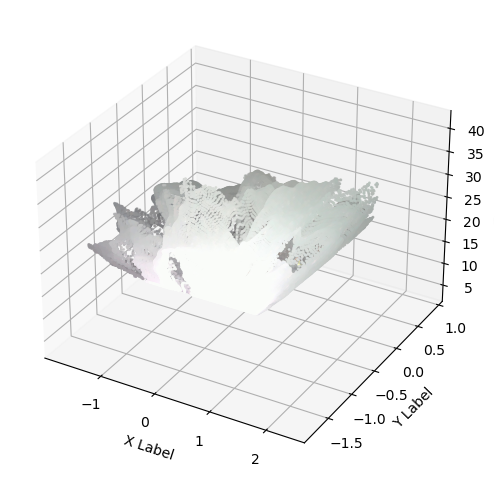

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creating a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting
scatter = ax.scatter(df['x'], df['y'], df['z'], c=df[['red', 'green', 'blue']] / 255, s=1)  # Assuming color values are in [0, 255]

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

# https://github.com/isl-org/ZoeDepth/blob/main/ui/gradio_im_to_3d.py